In [34]:
import pandas as pd
import contractions
import emoji
import re
import unicodedata
import nltk
import spacy
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading data from source 
df = pd.read_csv(r"C:\Playground\Toxicity_Classification\data\training\train.csv")

In [3]:
df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# dropping irrelevant features
df.drop('id', axis=1, inplace=True)

In [5]:
# Checking for duplicate instances
print(f"There are {df.duplicated().sum()} duplicate instaces")

There are 0 duplicate instaces


In [6]:
# Checking for null values
df.isna().sum().sum()

np.int64(0)

### Lower Case

In [7]:
# Making a deep copy of our data
df_copy = df.copy(deep=True)

In [8]:
def to_lowercase(text):
    """
    Convert the input text to lowercase.

    Parameters
    ----------
    text : str
        The text to convert.

    Returns
    -------
    str
        The text in lowercase.
    """
    return text.lower()


df_copy["preprocessed_text"] = df_copy["comment_text"].apply(to_lowercase)

### Removing http URLs

In [9]:
def remove_urls(text):
    """
    Remove URLs from the input text using a regular expression.

    Parameters
    ----------
    text : str
        The input text from which URLs will be removed.

    Returns
    -------
    str
        The text with all URLs removed.
    """
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)


# Apply the function to each text entry
df_copy['preprocessed_text'] = df_copy['preprocessed_text'].apply(remove_urls)


### Expanding Contractions

In [10]:
def expand_contractions(text):
    """
    Expand contractions in the input text.

    Parameters
    ----------
    text : str
        The text containing contractions to expand.

    Returns
    -------
    str
        The text with all contractions expanded.
    """
    return contractions.fix(text)


df_copy["preprocessed_text"] = df_copy["preprocessed_text"].apply(expand_contractions)


### Removing Accents/Diacritics

In [11]:
def remove_accents_diacritics(text):
    """
    Remove accents and diacritics from the input text.

    Parameters
    ----------
    text : str
        The text to normalize.

    Returns
    -------
    str
        The text with all accents and diacritics removed.
    """
    text = unicodedata.normalize('NFKD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])
    return text


df_copy['preprocessed_text'] = df_copy['preprocessed_text'].apply(remove_accents_diacritics)


### De-emojify the emojies into respective text

In [12]:
def convert_emojis(text):
    """
    Convert emojis in the input text into descriptive text labels.

    Parameters
    ----------
    text : str
        The text containing emojis to convert.

    Returns
    -------
    str
        The text with emojis replaced by their descriptive names.
    """
    return emoji.demojize(text)


df_copy['preprocessed_text'] = df_copy['preprocessed_text'].apply(convert_emojis)


### Removing mentions to other users

In [13]:
def remove_mentions(text: str) -> str:
    """
    Remove @mentions from the input text and normalize spacing.

    Parameters
    ----------
    text : str
        Input text that may contain @mentions.

    Returns
    -------
    str
        Text with all @mentions removed and extra spaces cleaned.
    """
    text = re.sub(r'@[A-Za-z0-9_.-]+', '', text)
    return " ".join(text.split())

df_copy['preprocessed_text'] = df_copy['preprocessed_text'].apply(remove_mentions)

### Removing numbers and punctuation

In [14]:
nlp = spacy.load("en_core_web_sm")

def spacy_remove_punct_numbers_pipe(text_list):
    """
    Clean a list of text documents using spaCy by removing punctuation and numbers.

    This function processes texts efficiently using spaCy's `nlp.pipe()` which supports
    batching and multiprocessing. It removes:
        - punctuation tokens
        - numeric tokens
        - any tokens that are not purely alphabetic

    Each token that passes the filter is lowercased and joined back into a space-
    separated cleaned string.

    Parameters
    ----------
    text_list : list of str
        A list containing text documents (one per row of your dataframe).

    Returns
    -------
    list of str
        A list of cleaned text strings corresponding to each input document, with
        punctuation and numbers removed.

    """
    
    total_docs = len(text_list)
    cleaned = []

    for doc in tqdm(
        nlp.pipe(text_list, batch_size=500, n_process=-1),
        total=total_docs,
        desc="Cleaning text (punct+numbers)",
        colour="green",
        ncols=100
    ):
        tokens = [token.text.lower() for token in doc if token.is_alpha]
        cleaned.append(" ".join(tokens))

    return cleaned


# Applying on column
df_copy["preprocessed_text"] = spacy_remove_punct_numbers_pipe(
    df_copy["preprocessed_text"].tolist()
)


Cleaning text (punct+numbers): 100%|███████████████████████| 159571/159571 [06:30<00:00, 408.97it/s]


### Lemmetization

In [15]:
def spacy_lemmatize_pipe(text_list):
    """
    Lemmatize a list of text documents using spaCy's optimized processing pipeline.

    This function applies lemmatization to each text in `text_list` using spaCy's
    `nlp.pipe()`, which supports efficient batched and parallel processing.
    Every token in each document is replaced with its lemma form, and the lemmas
    are joined back into a space-separated string.

    Parameters
    ----------
    text_list : list of str
        The input list of text documents to lemmatize.

    Returns
    -------
    list of str
        A list of lemmatized text strings, one for each input document.


    """
    
    total_docs = len(text_list)
    lemmatized = []

    for doc in tqdm(
        nlp.pipe(text_list, batch_size=500, n_process=-1),
        total=total_docs,
        desc="Lemmatizing with spaCy",
        colour="green",
        ncols=100
    ):
        lemmas = [token.lemma_ for token in doc]
        lemmatized.append(" ".join(lemmas))

    return lemmatized


# Apply on column
df_copy["preprocessed_text"] = spacy_lemmatize_pipe(
    df_copy["preprocessed_text"].tolist()
)


Lemmatizing with spaCy: 100%|██████████████████████████████| 159571/159571 [05:56<00:00, 448.01it/s]


### Converting Raw text into Tokens

In [16]:
def spacy_tokenize_pipe(text_list):
    """
    Tokenize a list of text documents using spaCy's high-performance pipeline.

    This function efficiently tokenizes each document in `text_list` by leveraging
    spaCy's `nlp.pipe()` for parallel, batched processing. It returns each document
    as a list of raw token strings.

    Parameters
    ----------
    text_list : list of str
        List of input text documents (e.g., each row of a DataFrame column).

    Returns
    -------
    list of list of str
        A list where each element corresponds to one document and contains the
        tokenized word strings.

    """

    total_docs = len(text_list)
    tokenized = []

    for doc in tqdm(
        nlp.pipe(text_list, batch_size=500, n_process=-1),
        total=total_docs,
        desc="Tokenizing with spaCy",
        colour="green",
        ncols=100
    ):
        tokenized.append([token.text for token in doc])

    return tokenized


# apply on the whole column
df_copy["preprocessed_text"] = spacy_tokenize_pipe(df_copy["preprocessed_text"].tolist())


Tokenizing with spaCy: 100%|███████████████████████████████| 159571/159571 [05:47<00:00, 459.60it/s]


In [17]:
df_copy['preprocessed_text'] = df_copy['preprocessed_text'].apply(lambda tokens: " ".join(tokens))

In [18]:
df_copy.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,preprocessed_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,he match this background colour I be seemingly...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man I be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more I can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir be my hero any chance you remember wha...


In [19]:
import gensim.downloader as api
print(api.info()['models'].keys())

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])


In [20]:
glove200_model = api.load('glove-twitter-200')

In [170]:
from keras.layers import TextVectorization, Embedding

sentences = df_copy['preprocessed_text'].tolist()

vectorizer = TextVectorization(
    max_tokens=50000,
    output_sequence_length=60,
    output_mode='int'
)
vectorizer.adapt(sentences)

In [171]:
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)
embedding_dim = glove200_model.vector_size

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for i, word in enumerate(vocab):
    if word in glove200_model:
        embedding_matrix[i] = glove200_model[word]

embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=True,
    mask_zero=True
)

In [172]:
from sklearn.model_selection import train_test_split
target_cols = [col for col in df.columns if df[col].dtype == 'int64']

X = df_copy['preprocessed_text']
y = df_copy[target_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [173]:
df_copy[target_cols]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


### Model Building

In [174]:
from keras.layers import GRU, Dense, BatchNormalization, LayerNormalization, Dropout, Activation, Input, Bidirectional
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import AUC

In [175]:
model = Sequential(name='aryan_bigru')
model.add(vectorizer)
model.add(embedding_layer)

model.add(Bidirectional(GRU(units=64, return_sequences=False)))
model.add(LayerNormalization())

model.add(Dense(16, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(8, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(4, kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Output layer (6 labels)
model.add(Dense(units=6, activation='sigmoid'))

model.summary()

Model: "aryan_bigru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_14           │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_14 (Embedding)        │ ?                      │    10,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_13          │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,000,000 (38.15 MB)

 Trainable params: 10,000,000 (38.15 MB)

 Non-trainable params: 0 (0.00 B)

### Using Focal loss

📘 Why I Used Focal Loss?

Focal Loss is a modified version of the standard Binary Cross-Entropy loss that is specifically designed to address extreme class imbalance, which is a major characteristic of toxic comment classification datasets. In this problem, most labels—such as threat, identity_hate, and severe_toxic—appear very rarely compared to common neutral comments. With regular BCE, the model quickly learns that predicting “all zeros” minimizes loss, because negative examples dominate the dataset. Focal Loss fixes this by reducing the contribution of easy, well-classified negatives and increasing the importance of hard, misclassified positives. In simple terms, the loss “focuses” on the minority toxic labels that the model struggles to learn. This helps the model avoid collapsing into predicting only zeros, improves recall on rare toxic categories, and generally leads to better macro-F1 performance in multilabel settings. Because of these advantages, Focal Loss is widely used in tasks involving severe imbalance, and is a strong choice for toxic comment classification.

In [176]:
from keras_cv.losses import FocalLoss # type: ignore
from tensorflow import keras
loss = FocalLoss(
    gamma=2.0,
    alpha=0.25
)

In [177]:
X_train = X_train.values
model.compile(optimizer=Nadam(), loss=loss, metrics=[keras.metrics.AUC(multi_label=True), keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

In [ ]:
model.evaluate(X_test.values, y_test)

998/998 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - auc_5: 0.9644 - loss: 0.0324 - precision_4: 0.8571 - recall_4: 0.5687


[0.03240986913442612,
 0.9644083976745605,
 0.8571428656578064,
 0.5687204003334045]

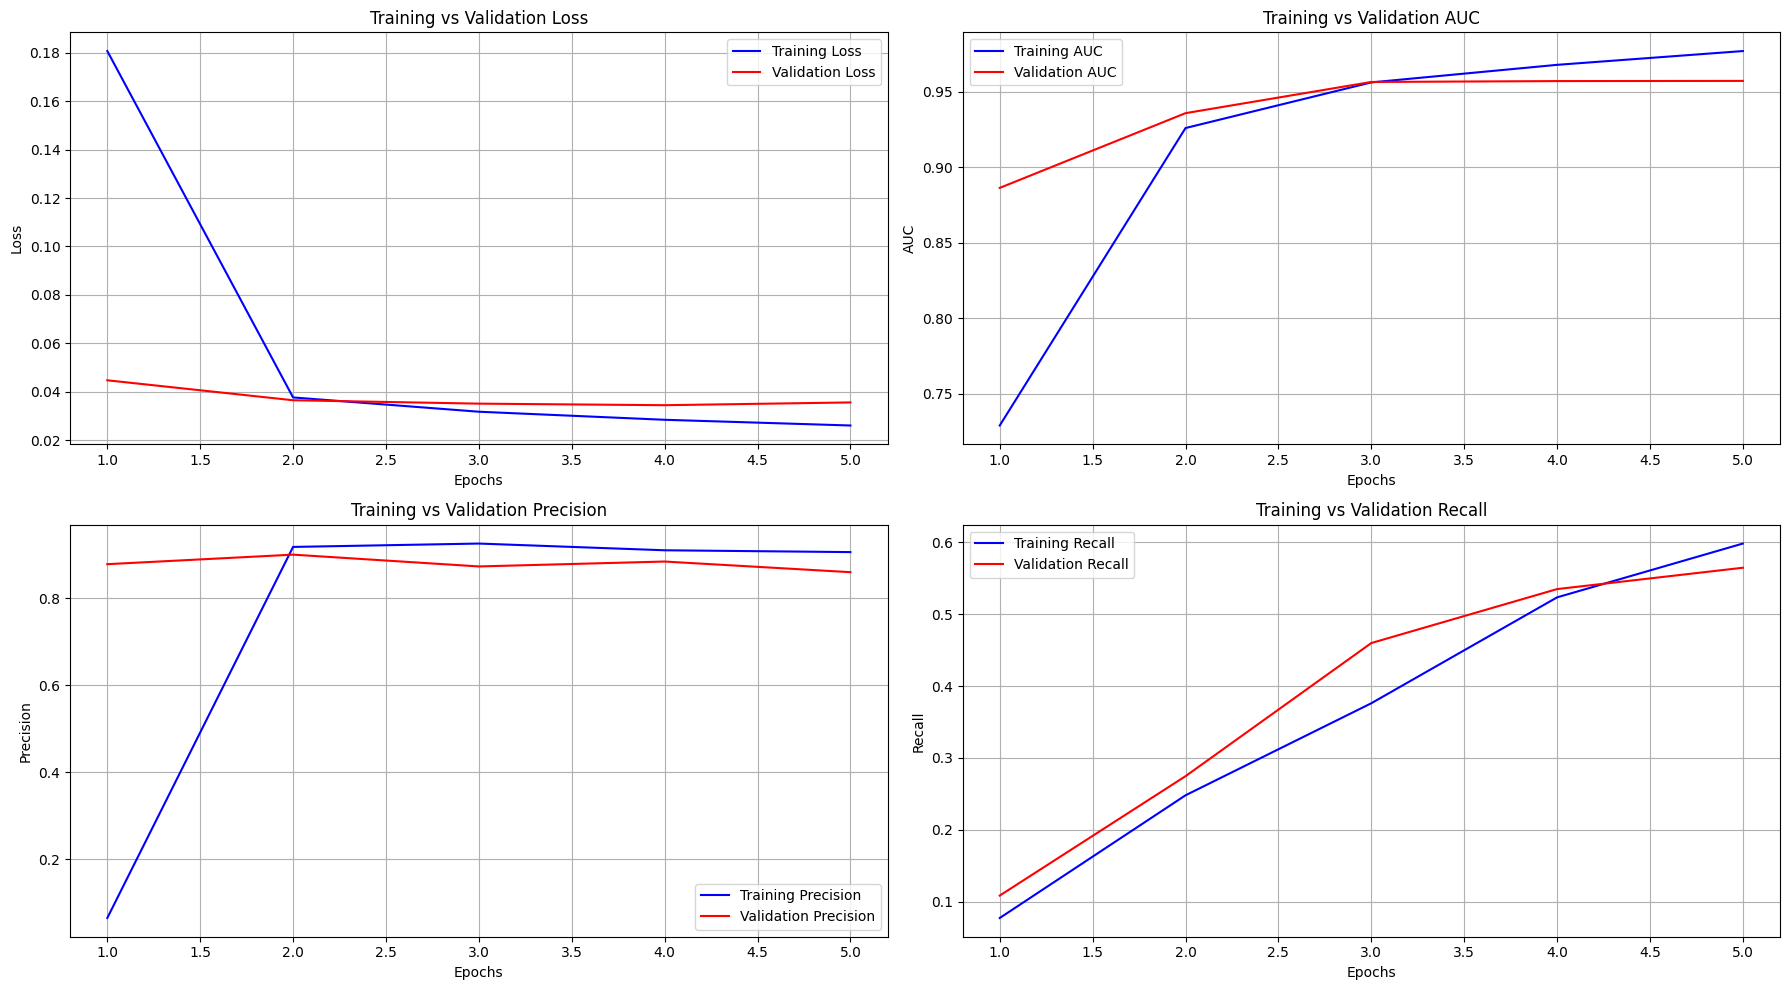

In [ ]:
# Extract loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract metrics
train_auc = history.history['auc_6']
val_auc = history.history['val_auc_6']

train_precision = history.history['precision_5']
val_precision = history.history['val_precision_5']

train_recall = history.history['recall_5']
val_recall = history.history['val_recall_5']

epochs = range(1, len(train_loss) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))

# ---- 1. Loss ----
plt.subplot(2,2,1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ---- 2. AUC ----
plt.subplot(2,2,2)
plt.plot(epochs, train_auc, 'b-', label='Training AUC')
plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
plt.title('Training vs Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

# ---- 3. Precision ----
plt.subplot(2,2,3)
plt.plot(epochs, train_precision, 'b-', label='Training Precision')
plt.plot(epochs, val_precision, 'r-', label='Validation Precision')
plt.title('Training vs Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# ---- 4. Recall ----
plt.subplot(2,2,4)
plt.plot(epochs, train_recall, 'b-', label='Training Recall')
plt.plot(epochs, val_recall, 'r-', label='Validation Recall')
plt.title('Training vs Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
